Descrição do problema:

Uma empresa de consultoria que atua em Big Data e Data Science deseja contratar 
Cientistas de Dados entre pessoas que obtenham aprovação em alguns cursos ministrados pela 
empresa.  
Muitas pessoas se inscrevem para o treinamento. A empresa quer saber quais desses 
candidatos realmente querem trabalhar para a empresa após o treinamento ou estão apenas 
fazendo o treinamento para retornarem ao mercado à procura de um novo emprego. O objetivo 
é contratar os profissionais com perfil adequado, a fim de reduzir o custo e o tempo de 
contratação, bem como a qualidade do treinamento ou planejamento dos cursos e categorização 
dos candidatos.  
Informações relacionadas a dados demográficos, educação e experiência estão 
disponíveis no conjunto de dados fornecido. 
Nosso objetivo será realizar um extenso trabalho de análise nos dados, compreender 
como estão organizados, realizar limpeza e transformação dos dados conforme necessário, 
detectar eventuais padrões e diagnósticos e ao final emitir um parecer com um resumo sobre os 
dados.

In [1]:
!pip install -q -U watermark

In [2]:
!pip install -q missingno

In [3]:
!pip install -q category_encoders

In [4]:
!pip install -q plotly

In [5]:
#Manipulação de dados
import pandas as pd
import numpy as np

#Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno

#Estatística
import scipy
from scipy.stats import normaltest
from scipy.stats import chi2_contingency

#Engenharia de Atributos 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

#Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [6]:
%reload_ext watermark
%watermark --iversions

matplotlib       : 3.8.0
category_encoders: 2.6.3
plotly           : 5.9.0
scipy            : 1.11.4
seaborn          : 0.12.2
pandas           : 2.1.4
sys              : 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
numpy            : 1.26.4
missingno        : 0.5.2



In [7]:
#Carregando dataset
df = pd.read_csv('dataset/aug_train.csv')

In [8]:
#Tirando as primeiras impressões dos dados
df.shape 

(19158, 14)

In [9]:
df.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [10]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [12]:
#Análise exploratória/ descrevendo os dados não númericos 
df.describe(include = object)

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,19158,14650,19158,18772,18698,16345,19093,13220,13018,18735
unique,123,3,2,3,5,6,22,8,6,6
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1
freq,4355,13221,13792,13817,11598,14492,3286,3083,9817,8040


In [13]:
#Descrevendo os dados númericos
df.describe().drop(columns = ['enrollee_id' , 'target'])

,city_development_index,training_hours
count,19158.000000,19158.000000
mean,0.828848,65.366896
std,0.123362,60.058462
min,0.448000,1.000000
25%,0.740000,23.000000
50%,0.903000,47.000000
75%,0.920000,88.000000
max,0.949000,336.000000


In [14]:
#Visualizando as váriaveis categóricas 
list(df.columns.values)[3:12]

['gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

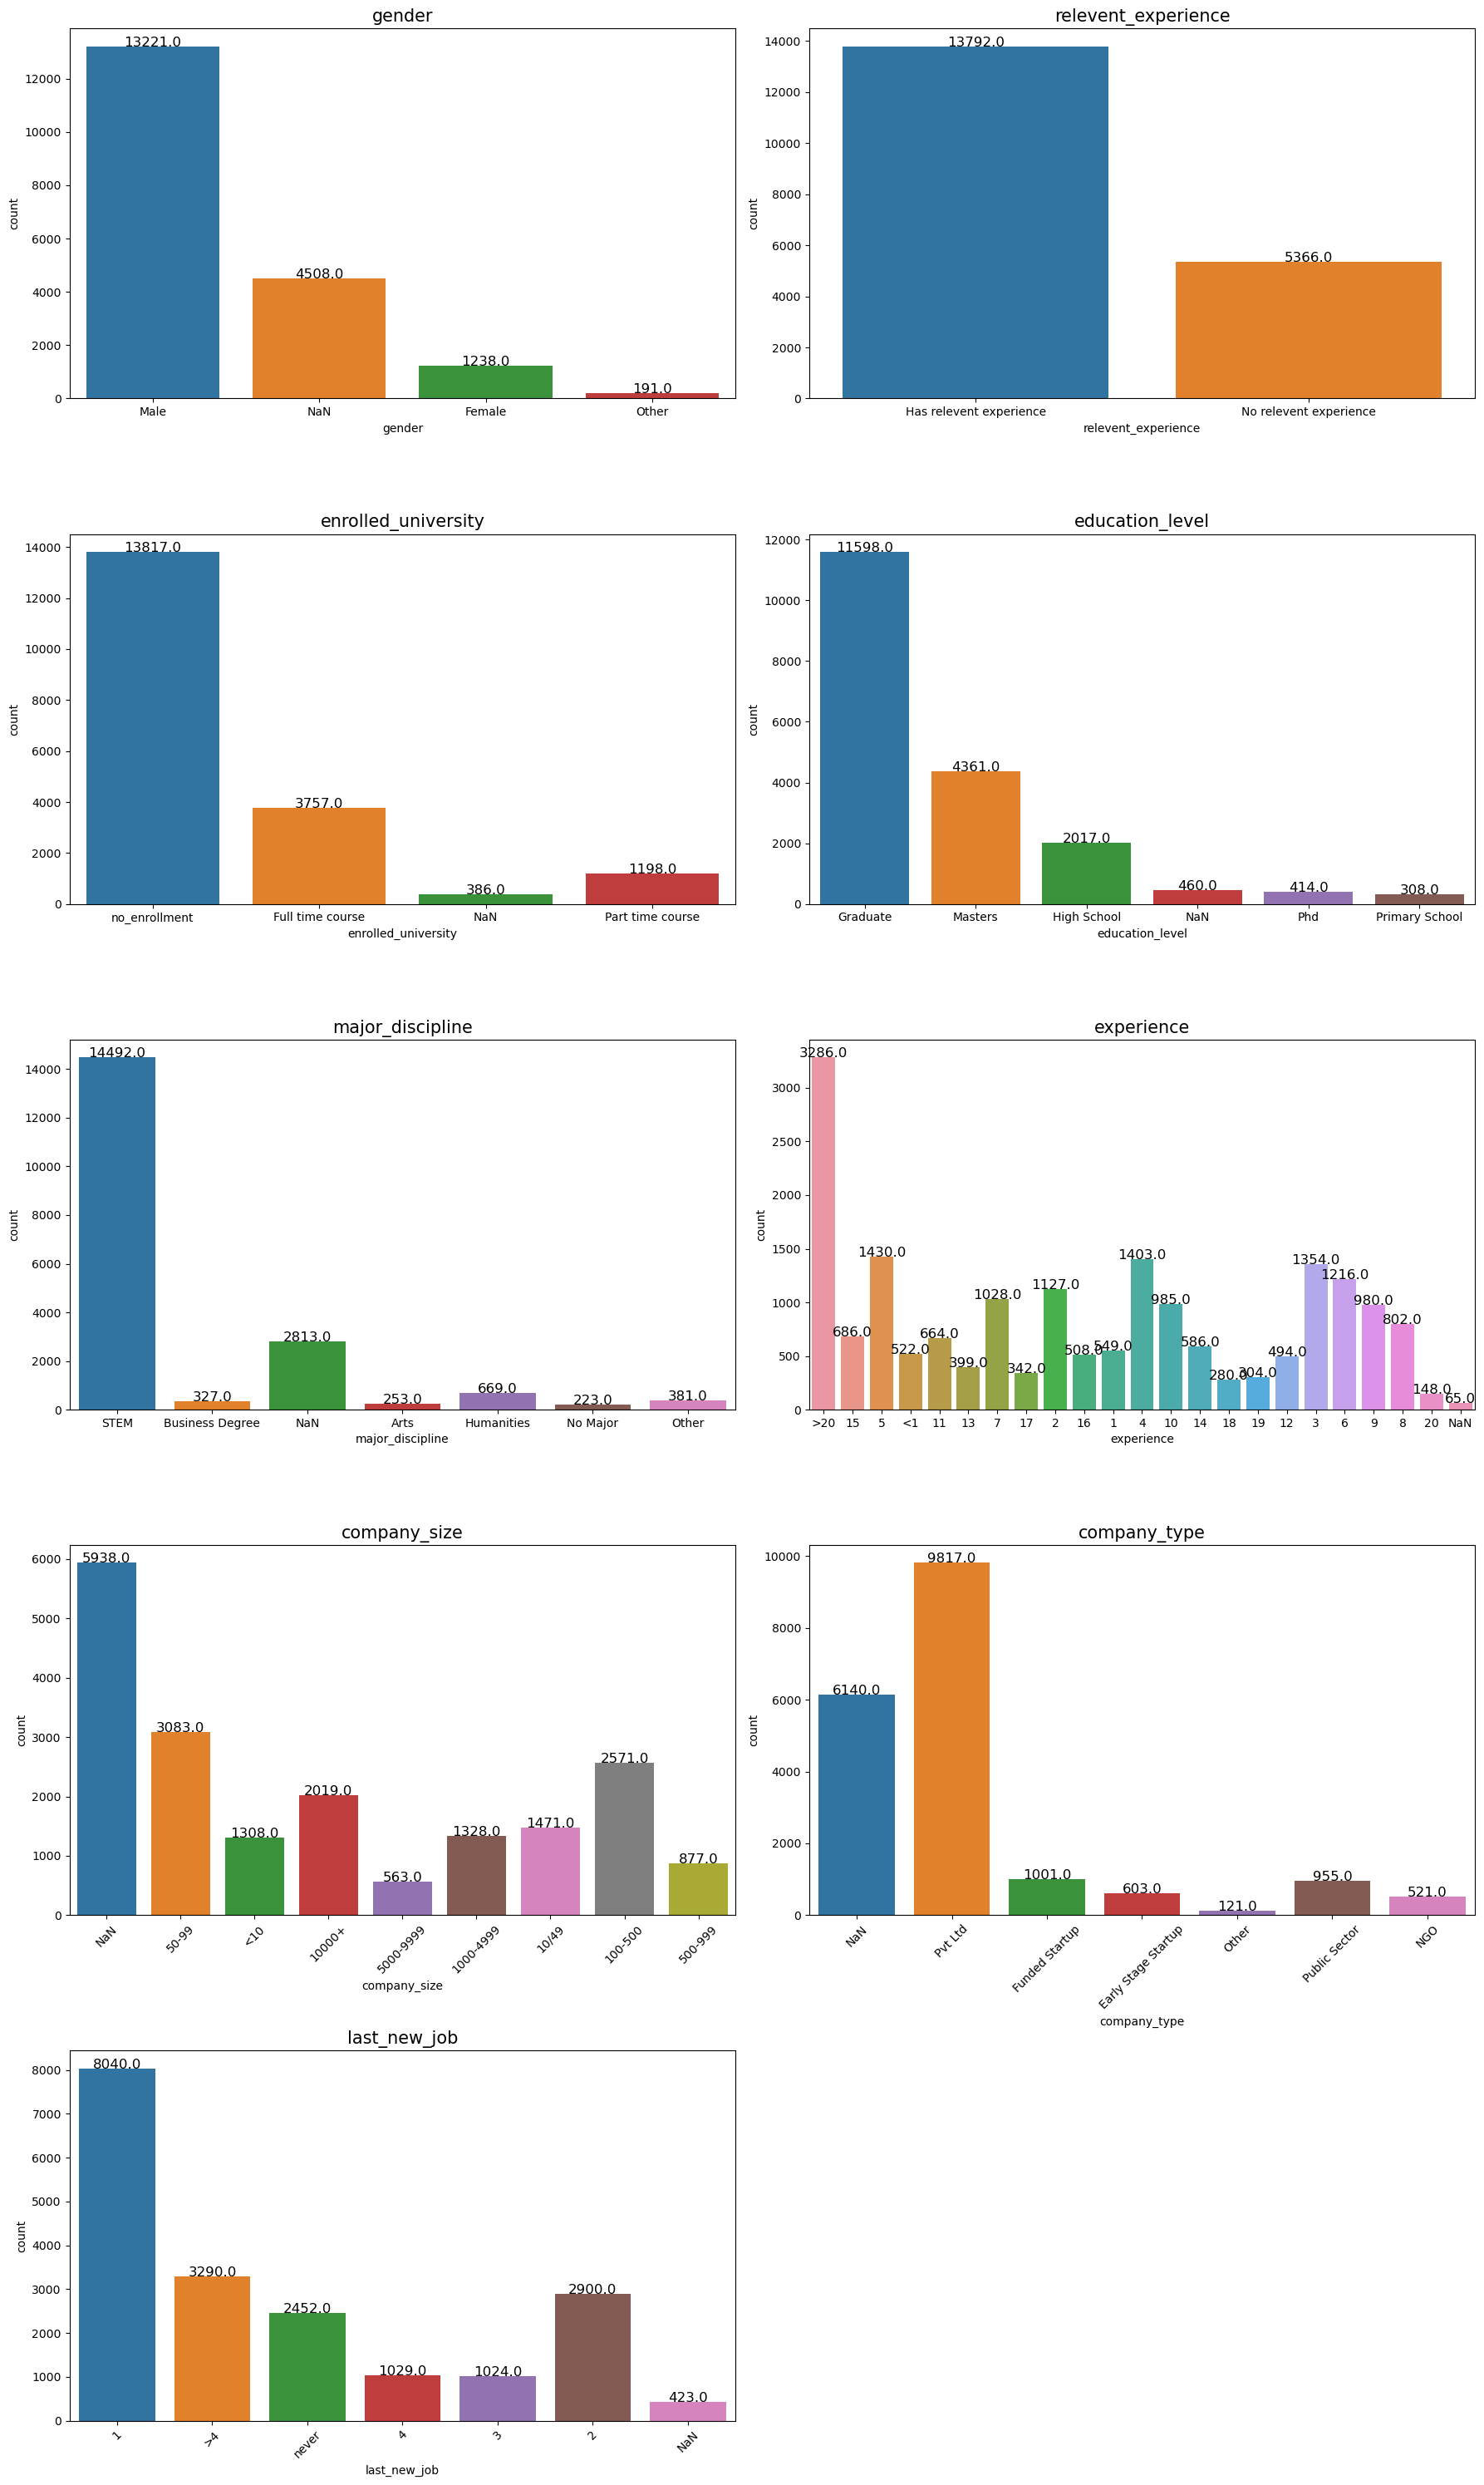

In [15]:
#Plot

#Tamanho da figura
plt.figure(figsize = (18,30))

#Lista de colunas
column_list = list(df.columns.values)[3:12]

#contador
A = 0

#Loop
for i in column_list:
    A += 1
    plt.subplot(5,2,A)
    ax = sns.countplot(data = df.fillna('NaN'), x = i)
    plt.title(i, fontsize = 15)
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 12)
        if A >= 7:
            plt.xticks(rotation = 45)

#Layout
plt.tight_layout(h_pad = 2)

In [16]:
#Verificando a distribuição das variáveis numéricas
#descrevendo os dados numéricos
df.describe().drop(columns = ['enrollee_id' , 'target'])

,city_development_index,training_hours
count,19158.000000,19158.000000
mean,0.828848,65.366896
std,0.123362,60.058462
min,0.448000,1.000000
25%,0.740000,23.000000
50%,0.903000,47.000000
75%,0.920000,88.000000
max,0.949000,336.000000


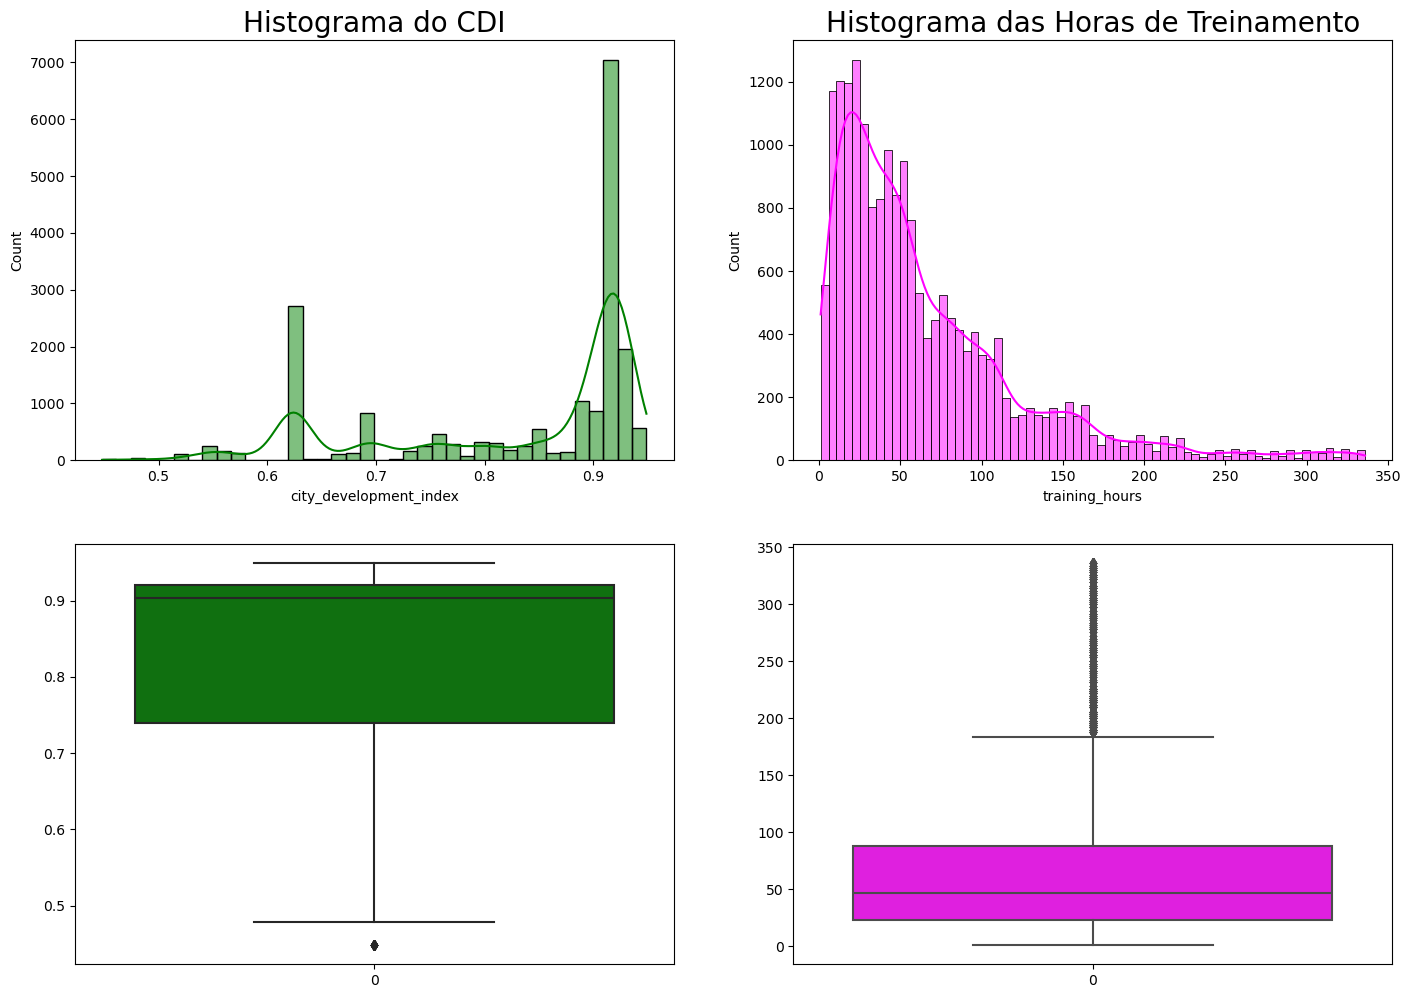

In [17]:
#figura
plt.figure(figsize = (17,12))

#subplots com histogramas
plt.subplot(221)
sns.color_palette("hls", 8)
sns.histplot(df['city_development_index'], kde = True, color = "green")
plt.title('Histograma do CDI', fontsize = 20)

plt.subplot(222)
sns.histplot(df['training_hours'], kde = True, color = "magenta")
plt.title('Histograma das Horas de Treinamento', fontsize = 20)

#subplots com boxplots
plt.subplot(223)
sns.boxplot(df['city_development_index'], color = "green")

plt.subplot(224)
sns.boxplot(df['training_hours'], color = "magenta")

plt.show()

In [18]:
#Teste de Normalidade da Distribuição 
#Usando o 'scipy' para fazer teste estatísco de distribuição

#Lista com as variáveis numéricas 
numerical_feature = ['city_development_index', 'training_hours']

#Loop
for i in numerical_feature:

    #Calcula a normalidade
    stats, pval = normaltest(df[i])

    #checar valor-p(valor de probabilidade)
    if pval > 0.05:
        print (i, ': Distribuição Normal')
    else:
        print(i, ': Distribuição Não Normal')

city_development_index : Distribuição Não Normal
training_hours : Distribuição Não Normal


In [19]:
#Correlação dos Dados
#Correlação de Spearman entre variáveis numéricas 

In [20]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [21]:
df.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [22]:
#Criando uma cópia do dataframe original
df_numerical = df.copy()

In [23]:
df_numerical['experience'].value_counts()

experience
>20    3286
5      1430
4      1403
3      1354
6      1216
2      1127
7      1028
10      985
9       980
8       802
15      686
11      664
14      586
1       549
<1      522
16      508
12      494
13      399
17      342
19      304
18      280
20      148
Name: count, dtype: int64

In [24]:
#Convertendo a variável experience para númerica
df_numerical['experience'] = np.where(df_numerical['experience'] == '<1', 1, df_numerical['experience'])
df_numerical['experience'] = np.where(df_numerical['experience'] == '>20', 21, df_numerical['experience'])
df_numerical['experience'] = df_numerical['experience'].astype(float)

In [25]:
df_numerical['experience'].value_counts()

experience
21.0    3286
5.0     1430
4.0     1403
3.0     1354
6.0     1216
2.0     1127
1.0     1071
7.0     1028
10.0     985
9.0      980
8.0      802
15.0     686
11.0     664
14.0     586
16.0     508
12.0     494
13.0     399
17.0     342
19.0     304
18.0     280
20.0     148
Name: count, dtype: int64

In [26]:
df_numerical['last_new_job'].value_counts()

last_new_job
1        8040
>4       3290
2        2900
never    2452
4        1029
3        1024
Name: count, dtype: int64

In [27]:
#Convertendo a variável last_new_job para númerica
df_numerical['last_new_job'] = np.where(df_numerical['last_new_job'] == 'never', 0, df_numerical['last_new_job'])
df_numerical['last_new_job'] = np.where(df_numerical['last_new_job'] == '>4', 5, df_numerical['last_new_job'])
df_numerical['last_new_job'] = df_numerical['last_new_job'].astype(float)

In [28]:
df_numerical['last_new_job'].value_counts()

last_new_job
1.0    8040
5.0    3290
2.0    2900
0.0    2452
4.0    1029
3.0    1024
Name: count, dtype: int64

In [29]:
df_numerical.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21.0,NaN,NaN,1.0,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,5.0,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5.0,NaN,NaN,0.0,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,1.0,NaN,Pvt Ltd,0.0,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,21.0,50-99,Funded Startup,4.0,8,0.0


In [30]:
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  float64
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  float64
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(4), int64(2), object(8)
mem

In [31]:
drop = ['enrollee_id', 'city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'company_size', 'company_type']   
df_numerical.drop(drop, axis = 1).corr("spearman")

,city_development_index,experience,last_new_job,training_hours,target
city_development_index,1.000000,0.300997,0.182698,0.007491,-0.279165
experience,0.300997,1.000000,0.473284,0.003569,-0.183721
last_new_job,0.182698,0.473284,1.000000,0.002959,-0.082045
training_hours,0.007491,0.003569,0.002959,1.000000,-0.014126
target,-0.279165,-0.183721,-0.082045,-0.014126,1.000000


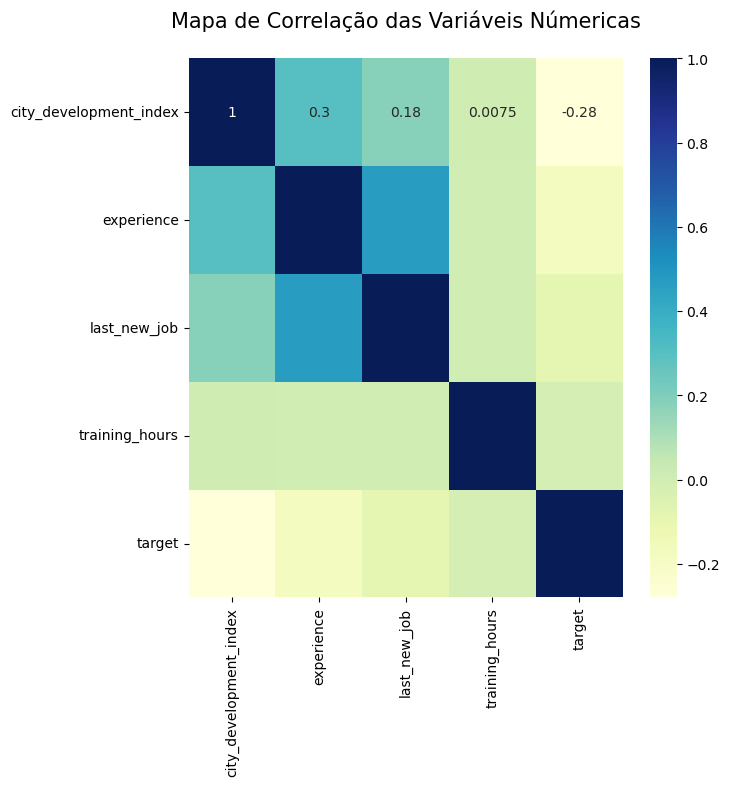

In [32]:
#Heatmap
plt.figure(figsize = (7,7))
sns.heatmap(df_numerical.drop(drop, axis = 1).corr('spearman'), annot = True, cmap = 'YlGnBu')
plt.title('Mapa de Correlação das Variáveis Númericas\n', fontsize = 15)
plt.show()

In [33]:
#Utilizando WOE(Weight of evidence) e o IV(Information Value)
#Loop
for i in df.drop(columns = ['target',
                            'enrollee_id',
                            'city',
                            'city_development_index',
                            'training_hours',
                            'experience',
                            'last_new_job',
                            'company_size']).columns:
    df_woe_iv = (pd.crosstab(df[i], df['target'], normalize = 'columns')
                 .assign(woe = lambda dfx: np.log(dfx[1] / dfx[0]))
                 .assign(iv = lambda dfx: np.sum(dfx['woe'] * (dfx[1]-dfx[0]))))
    print(df_woe_iv, '\n----------------------------------------------------------')

target      0.0       1.0       woe        iv
gender                                       
Female  0.08098  0.096222  0.172452  0.003337
Male    0.90650  0.889020 -0.019471  0.003337
Other   0.01252  0.014758  0.164458  0.003337 
----------------------------------------------------------
target                        0.0       1.0       woe        iv
relevent_experience                                            
Has relevent experience  0.753147  0.619845 -0.194790  0.083523
No relevent experience   0.246853  0.380155  0.431784  0.083523 
----------------------------------------------------------
target                    0.0       1.0       woe        iv
enrolled_university                                        
Full time course     0.164754  0.307477  0.623947  0.118886
Part time course     0.063465  0.064890  0.022210  0.118886
no_enrollment        0.771781  0.627632 -0.206746  0.118886 
----------------------------------------------------------
target                0.0       1.

<Figure size 1000x1200 with 0 Axes>

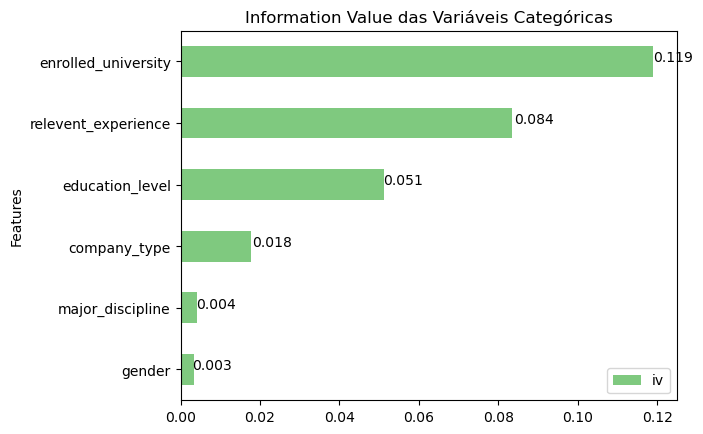

In [34]:
#Plot do Information Value

#Variáveis categóricas
columns_cat = df.drop(columns= ['target',
                                'enrollee_id',
                                'city',
                                'city_development_index',
                                'training_hours',
                                'experience',
                                'last_new_job',
                                'company_size']).columns
#Lista para o IV
iv = []

#Loop
for i in columns_cat:
    df_woe_iv = (pd.crosstab(df[i], df['target'], normalize = 'columns')
                 .assign(woe = lambda dfx: np.log(dfx[1] / dfx[0]))
                 .assign(iv = lambda dfx: np.sum(dfx['woe'] * (dfx[1]-dfx[0]))))
    iv.append(df_woe_iv['iv'][0])

#Dataframe
df_iv = pd.DataFrame({'Features':columns_cat, 'iv':iv}).set_index('Features').sort_values(by = 'iv')

#Plot
#Figura
plt.figure(figsize = (10,12))
df_iv.plot(kind = 'barh', title = 'Information Value das Variáveis Categóricas', colormap = 'Accent')
for index, value in enumerate(list(round(df_iv['iv'], 3))):
    plt.text((value), index, str(value))
plt.legend(loc = 'lower right')
plt.show()

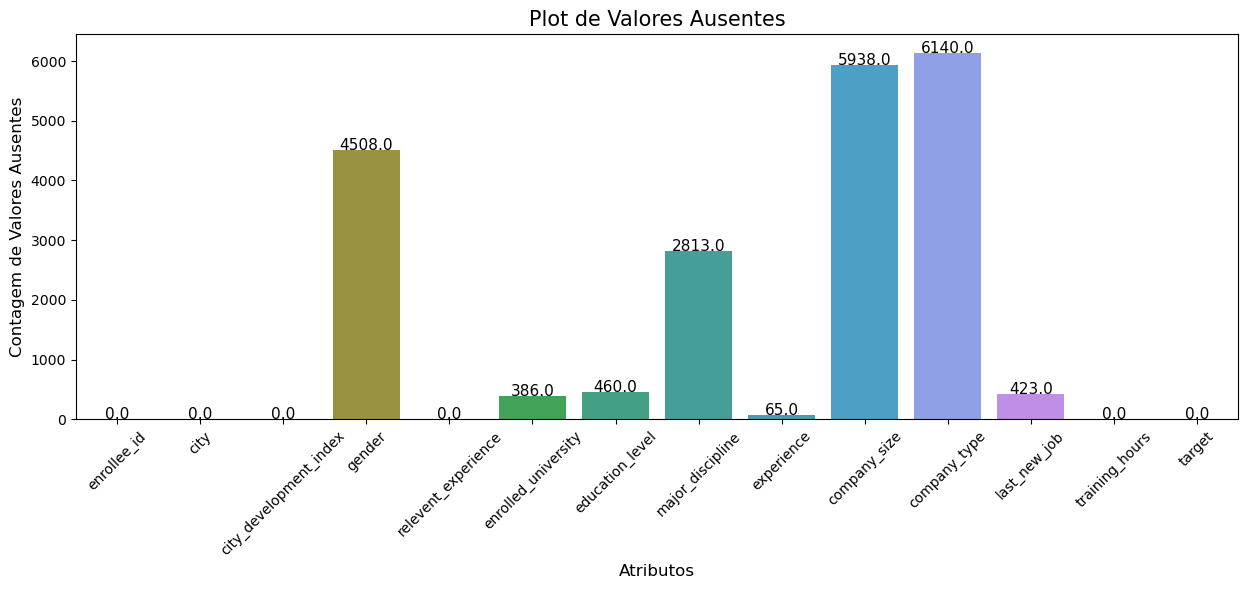

In [35]:
#Identificando valores ausentes
#valores por coluna
null_df = df.isna().sum().reset_index()

# figura
fig, ax = plt.subplots(figsize=(15, 5))

# Barplot
sns.barplot(x=null_df['index'], y=null_df[0], palette='husl', ax=ax)
plt.xlabel('Atributos', fontsize=12)
plt.ylabel('Contagem de Valores Ausentes', fontsize=12)
plt.xticks(rotation=45)
plt.title('Plot de Valores Ausentes', fontsize=15)

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, (p.get_height())), ha='center', color='black', size=11)

plt.show()

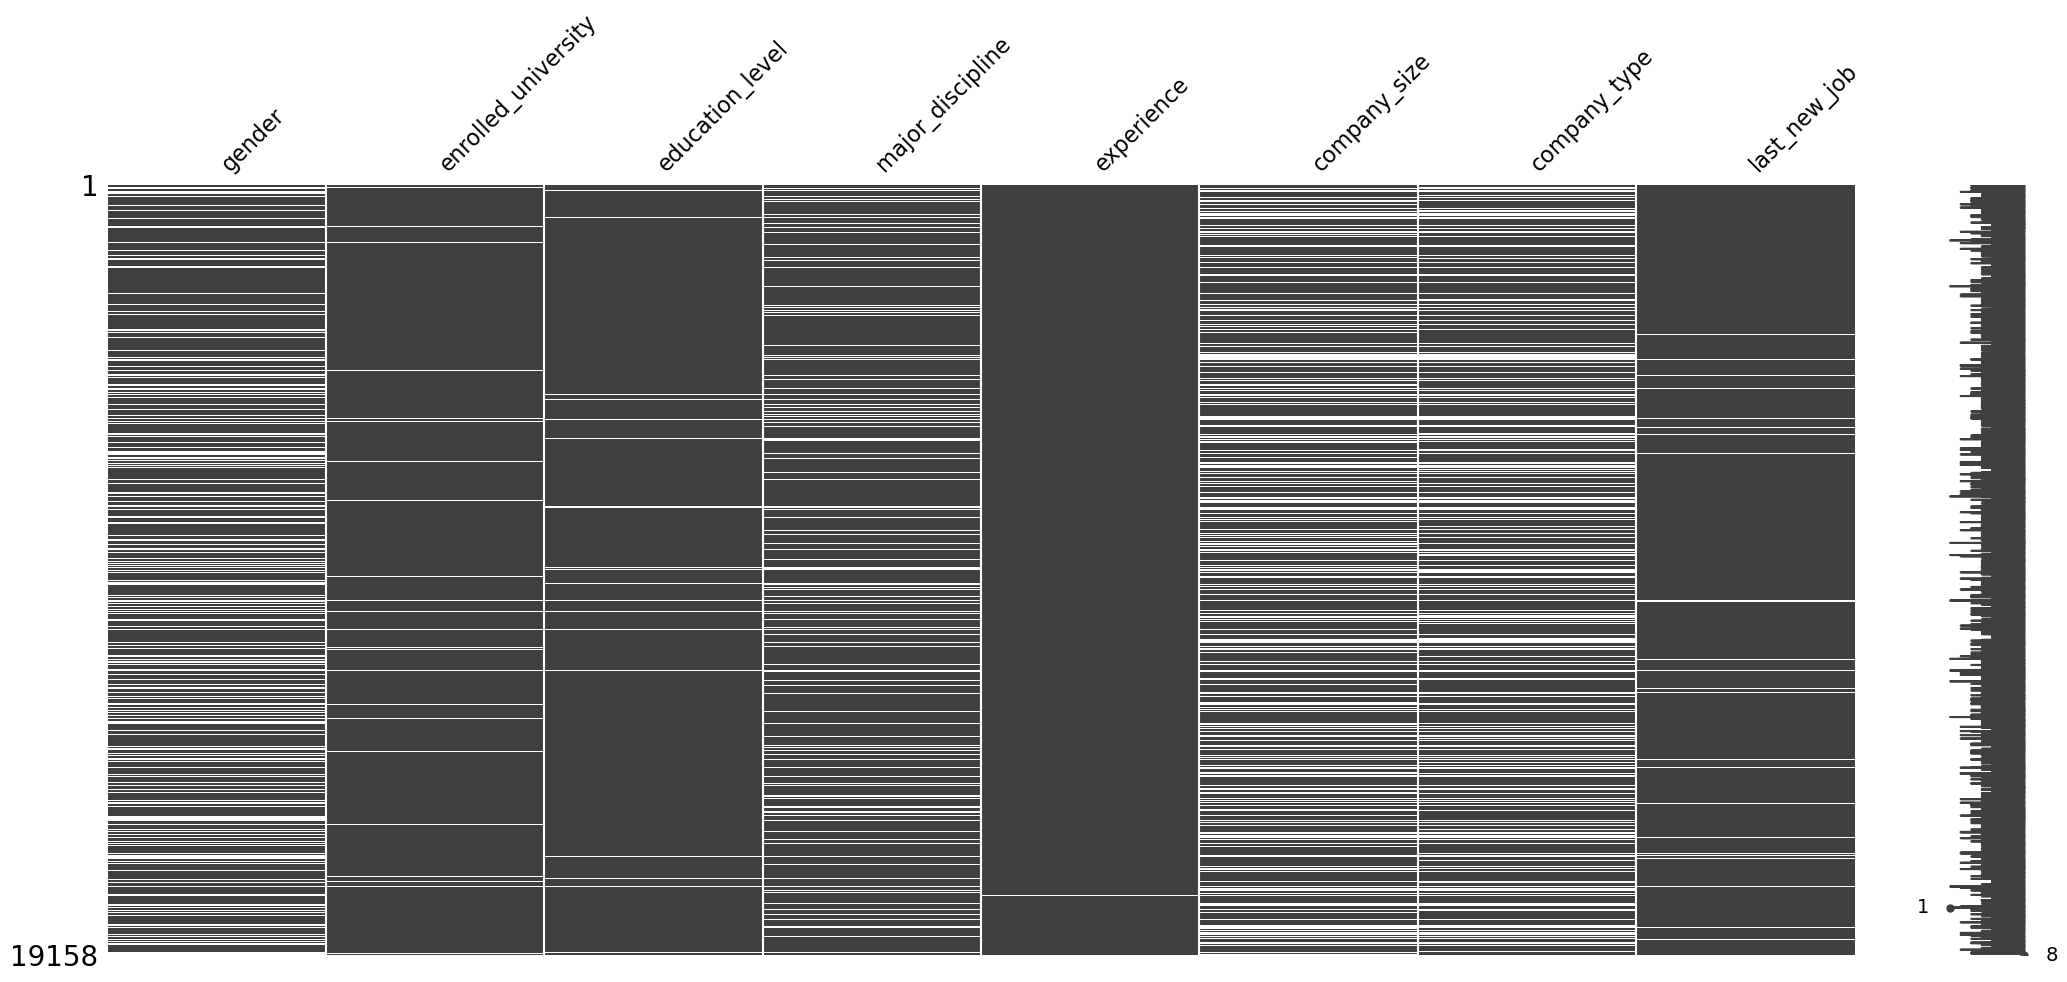

In [36]:
#Gera a visualização 

#DataFrame
df_nan = pd.DataFrame(df.isna().sum())

#Plot - Mapa de Valores Ausentes
if df.isna().any(axis=None):
    missingno.matrix(df[df_nan[df_nan[0]>0].index])
    plt.show()

In [37]:
#Checando valores duplicados
df['enrollee_id'].duplicated().sum()

0

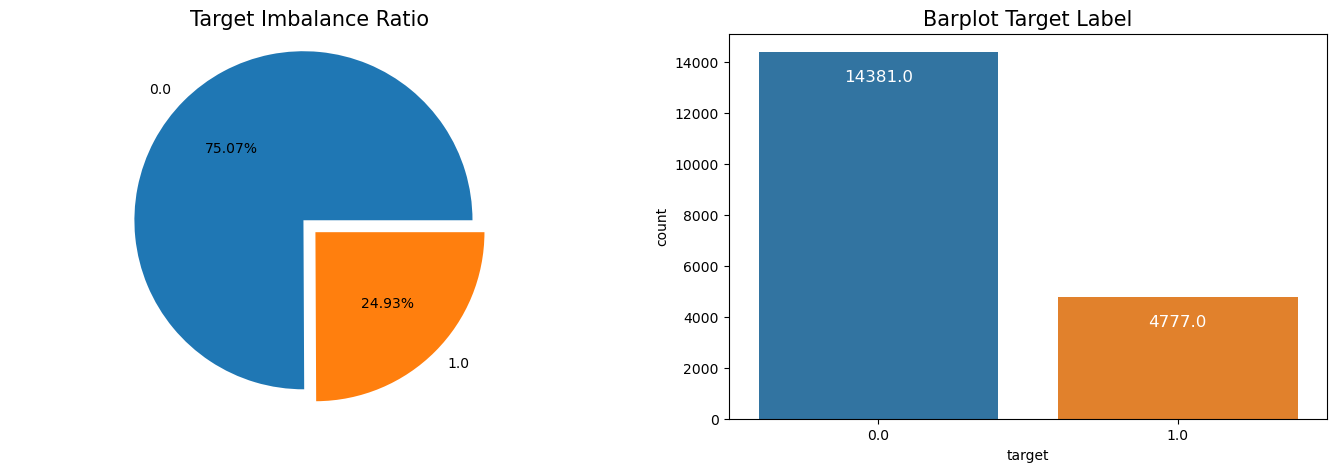

In [38]:
#figura
plt.figure(figsize = (17,(100)/20))

plt.subplot(121)
plt.pie(round(df['target'].value_counts() / len(df) * 100,2),
        labels = list(df['target'].value_counts().index),
        autopct = '%.2f%%',
        explode = (0,0.1))

plt.axis('equal')
plt.title('Target Imbalance Ratio', size = 15)

plt.subplot(122)
ax = sns.countplot(data = df, x = 'target')
plt.title('Barplot Target Label', fontsize = 15)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}',
                (p.get_x()+0.4,
                 p.get_height()),
                ha = 'center',
                va = 'top',
                color = 'white',
                size = 12)

In [39]:
#Limpeza e processamento dos Dados
#Tratando os valores ausentes
df.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [40]:
colunas_manter = ['city_development_index',
                  'experience',
                  'enrolled_university',
                  'relevent_experience',
                  'education_level',
                  'company_type',
                  'major_discipline',
                  'target']

In [41]:
new_df = df[colunas_manter]

In [42]:
new_df.head()

,city_development_index,experience,enrolled_university,relevent_experience,education_level,company_type,major_discipline,target
0,0.920,>20,no_enrollment,Has relevent experience,Graduate,NaN,STEM,1.0
1,0.776,15,no_enrollment,No relevent experience,Graduate,Pvt Ltd,STEM,0.0
2,0.624,5,Full time course,No relevent experience,Graduate,NaN,STEM,0.0
3,0.789,<1,NaN,No relevent experience,Graduate,Pvt Ltd,Business Degree,1.0
4,0.767,>20,no_enrollment,Has relevent experience,Masters,Funded Startup,STEM,0.0


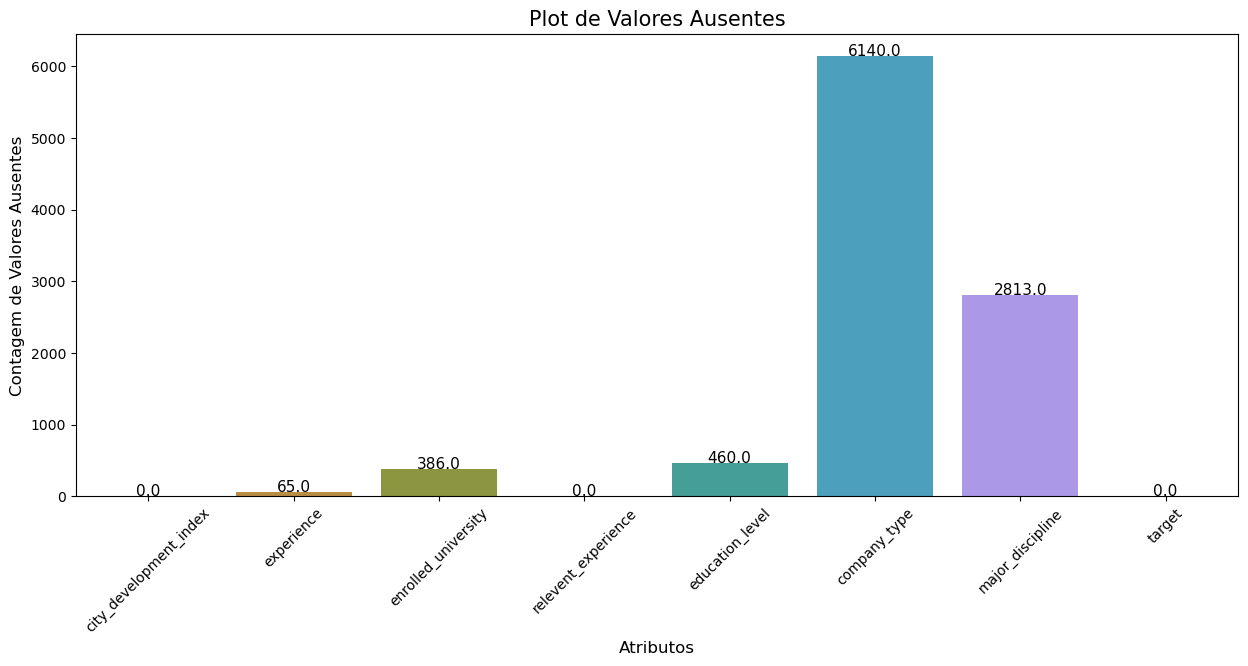

In [43]:
#Valores ausentes por coluna
null_df = new_df.isna().sum().reset_index()

#figura
fig, ax = plt.subplots(figsize=(15, 6))

#Barplot
sns.barplot(x = null_df['index'], y = null_df[0], palette = 'husl')
plt.xlabel('Atributos', fontsize = 12)
plt.ylabel('Contagem de Valores Ausentes', fontsize = 12)
plt.xticks(rotation = 45)
plt.title('Plot de Valores Ausentes', fontsize = 15)

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, (p.get_height())), ha = 'center', color = 'black', size = 11)

plt.show()

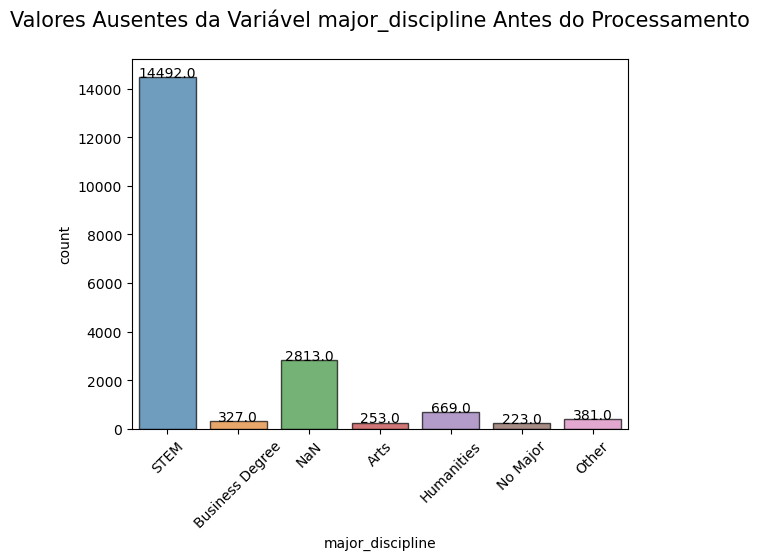

In [44]:
#Adotamos uma estratégia para cada variável que apresentou valor ausente
#Variável major_discipline
#Valores ausentes da variável major_discipline antes do processamento
sns.countplot(data= new_df.fillna('NaN'), x = 'major_discipline', alpha = 0.7, edgecolor = 'black')
plt.xticks(rotation = 45)
bound = ax.get_xbound()
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 10)
plt.title('Valores Ausentes da Variável major_discipline Antes do Processamento\n', fontsize = 15)
plt.show()

In [45]:
#Relação entre major_discipline x education_level
print('\nTotal de Valores Ausentes na Variável major_discipline:', new_df['major_discipline'].isna().sum())
print('\nProporção de Valores Ausentes na Variável education_level:')
new_df[new_df['major_discipline'].isna()]['education_level'].value_counts(dropna = False)


Total de Valores Ausentes na Variável major_discipline: 2813

Proporção de Valores Ausentes na Variável education_level:


education_level
High School       2017
NaN                460
Primary School     308
Graduate            22
Masters              6
Name: count, dtype: int64

In [46]:
#Cria o índice
nan_index = (new_df[(new_df['major_discipline'].isna()) & ((new_df['education_level']=='High School') | (new_df['education_level'].isna()) | (new_df['education_level']=='Primary School'))]).index

In [47]:
len(nan_index)

2785

In [48]:
#Imputação do valor ausente
new_df['major_discipline'][nan_index] = 'Non Degree'

In [49]:
print('Total de Valores Ausentes na Variável major_discipline:', new_df['major_discipline'].isna().sum())
new_df['major_discipline'].value_counts(dropna = False)

Total de Valores Ausentes na Variável major_discipline: 28


major_discipline
STEM               14492
Non Degree          2785
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
NaN                   28
Name: count, dtype: int64

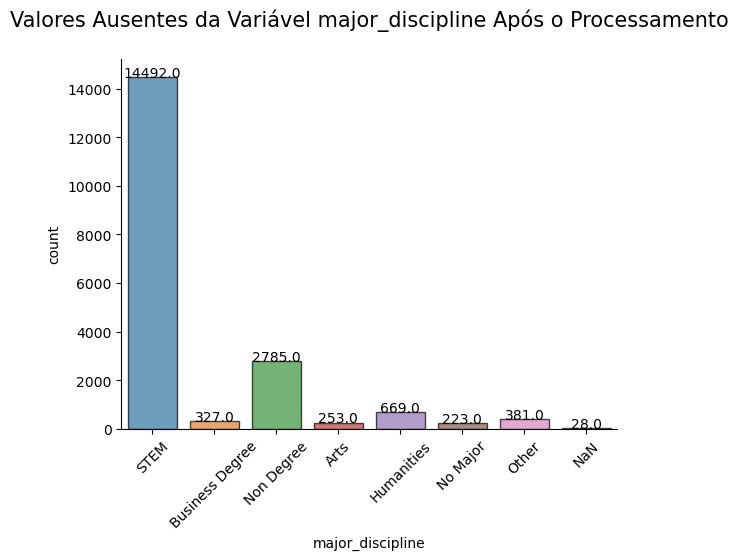

In [50]:
#valores ausentes da variável major_discipline após o processamento 
sns.countplot(data= new_df.fillna('NaN'), x= 'major_discipline', alpha = 0.7, edgecolor = 'black')
sns.despine()
plt.xticks(rotation=45)
bound=ax.get_xbound()
ax=plt.gca()
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 10)
plt.title('Valores Ausentes da Variável major_discipline Após o Processamento\n', fontsize = 15)
plt.show()

In [51]:
#Para os valores ausentes restantes preenchemos com 'other'
new_df[new_df['major_discipline'].isna()] = 'Other'

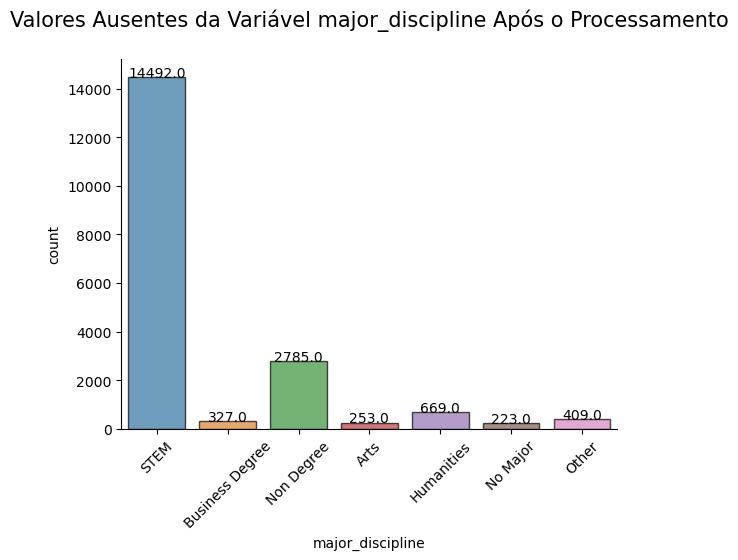

In [52]:
#valores ausentes da variável major_discipline após o processamento 
sns.countplot(data= new_df.fillna('NaN'), x= 'major_discipline', alpha = 0.7, edgecolor = 'black')
sns.despine()
plt.xticks(rotation=45)
bound=ax.get_xbound()
ax=plt.gca()
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 10)
plt.title('Valores Ausentes da Variável major_discipline Após o Processamento\n', fontsize = 15)
plt.show()

In [53]:
new_df.head()

,city_development_index,experience,enrolled_university,relevent_experience,education_level,company_type,major_discipline,target
0,0.92,>20,no_enrollment,Has relevent experience,Graduate,NaN,STEM,1.0
1,0.776,15,no_enrollment,No relevent experience,Graduate,Pvt Ltd,STEM,0.0
2,0.624,5,Full time course,No relevent experience,Graduate,NaN,STEM,0.0
3,0.789,<1,NaN,No relevent experience,Graduate,Pvt Ltd,Business Degree,1.0
4,0.767,>20,no_enrollment,Has relevent experience,Masters,Funded Startup,STEM,0.0


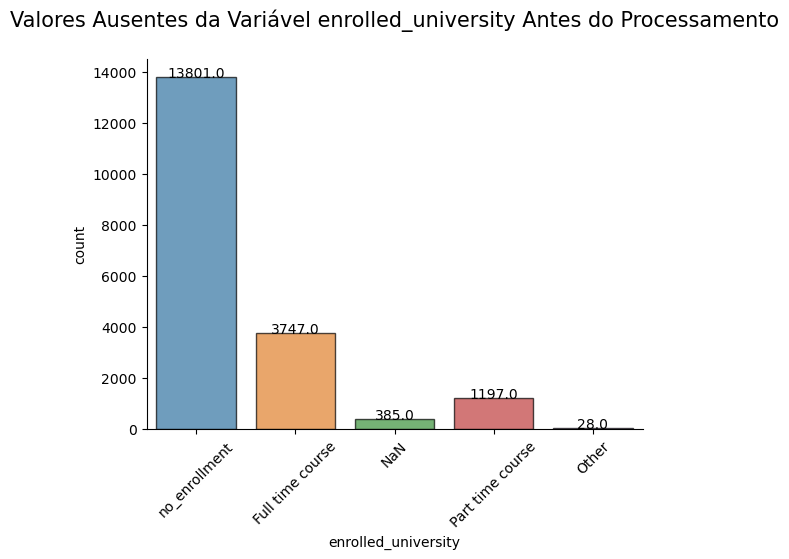

In [54]:
#Plot
sns.countplot(data= new_df.fillna('NaN'), x= 'enrolled_university', alpha = 0.7, edgecolor = 'black')
sns.despine()
plt.xticks(rotation=45)
bound=ax.get_xbound()
ax=plt.gca()
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 10)
plt.title('Valores Ausentes da Variável enrolled_university Antes do Processamento\n', fontsize = 15)
plt.show()

In [55]:
print('\nTotal de Valores Ausentes na Variável enrolled_university:', new_df['enrolled_university'].isna().sum())
print('\nProporção de Valores Ausentes na Variável education_level:')
new_df[new_df['enrolled_university'].isna()]['education_level'].value_counts(dropna = False)


Total de Valores Ausentes na Variável enrolled_university: 385

Proporção de Valores Ausentes na Variável education_level:


education_level
Graduate          170
NaN               100
Masters            53
High School        47
Primary School      9
Phd                 6
Name: count, dtype: int64

In [56]:
#Preparando o índice
nan_index = (new_df[(new_df['enrolled_university'].isna()) & (new_df['education_level'] =='Primary School')]).index

In [57]:
len(nan_index)

9

In [58]:
#imputação de valores ausentes
new_df['enrolled_university'][nan_index] = 'Primary Grad'

In [59]:
print('Total de Valores Ausentes:', new_df['enrolled_university'].isna().sum())
new_df[new_df['enrolled_university'].isna()]['education_level'].value_counts(dropna = False)

Total de Valores Ausentes: 376


education_level
Graduate       170
NaN            100
Masters         53
High School     47
Phd              6
Name: count, dtype: int64

In [60]:
nan_index = new_df[(new_df['enrolled_university'].isna())].index

In [61]:
#o restante colocamos como 'other'
new_df['enrolled_university'][nan_index] = 'Other'

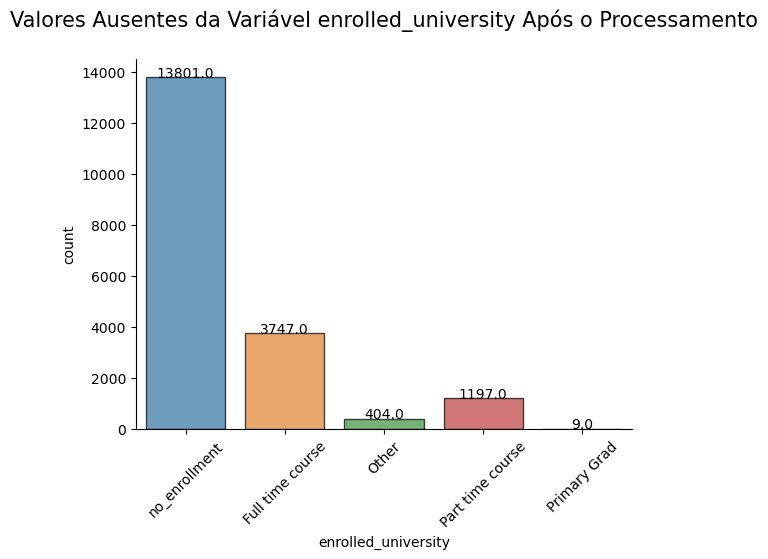

In [62]:
#Plot
sns.countplot(data= new_df.fillna('NaN'), x= 'enrolled_university', alpha = 0.7, edgecolor = 'black')
sns.despine()
plt.xticks(rotation=45)
bound=ax.get_xbound()
ax=plt.gca()
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 10)
plt.title('Valores Ausentes da Variável enrolled_university Após o Processamento\n', fontsize = 15)
plt.show()

In [63]:
new_df.head()

,city_development_index,experience,enrolled_university,relevent_experience,education_level,company_type,major_discipline,target
0,0.92,>20,no_enrollment,Has relevent experience,Graduate,NaN,STEM,1.0
1,0.776,15,no_enrollment,No relevent experience,Graduate,Pvt Ltd,STEM,0.0
2,0.624,5,Full time course,No relevent experience,Graduate,NaN,STEM,0.0
3,0.789,<1,Other,No relevent experience,Graduate,Pvt Ltd,Business Degree,1.0
4,0.767,>20,no_enrollment,Has relevent experience,Masters,Funded Startup,STEM,0.0


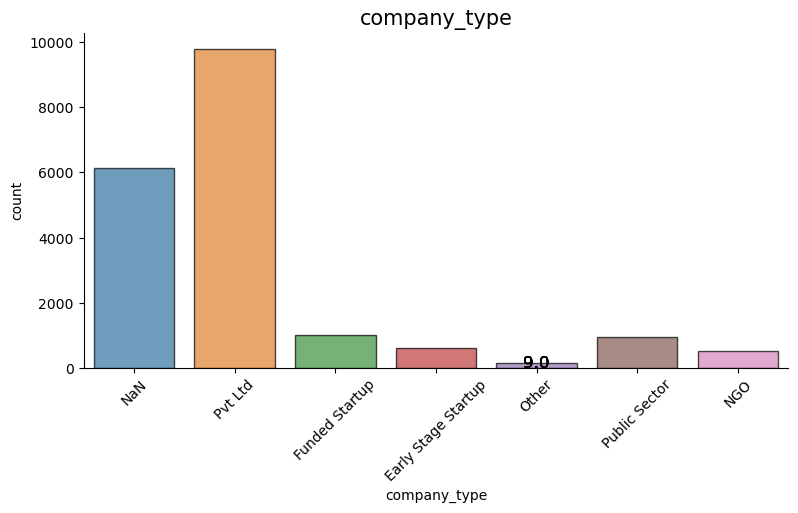

In [64]:
#plot
plt.figure(figsize = (20, 20))
column_list = ['company_type']
A = 0
for i in column_list:
    A+=1
    plt.subplot(4,2,A)
    ax = sns.countplot(data = new_df.fillna('NaN'), x = i, alpha = 0.7, edgecolor = 'black')
    sns.despine()
    plt.title(i, fontsize = 15)
    for i in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 12)
    if A >= 0:
        plt.xticks(rotation = 45)

In [65]:
new_df['company_type'].value_counts(dropna = False)

company_type
Pvt Ltd                9802
NaN                    6129
Funded Startup         1001
Public Sector           953
Early Stage Startup     603
NGO                     521
Other                   149
Name: count, dtype: int64

In [66]:
#índice
nan_index = new_df[(new_df['company_type'].isna())].index

In [67]:
#Imputação dos valores NaN com 'Other'
new_df['company_type'][nan_index] = 'Other'

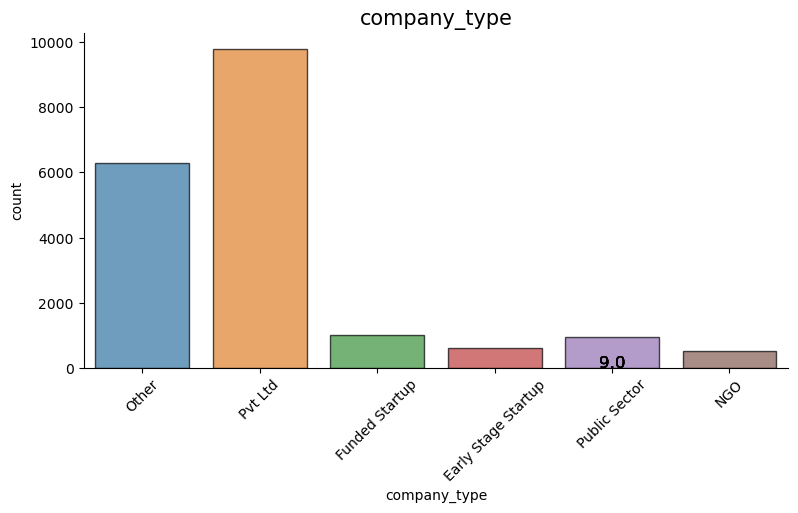

In [68]:
plt.figure(figsize = (20, 20))
column_list = ['company_type']
A = 0
for i in column_list:
    A+=1
    plt.subplot(4,2,A)
    ax = sns.countplot(data = new_df.fillna('NaN'), x = i, alpha = 0.7, edgecolor = 'black')
    sns.despine()
    plt.title(i, fontsize = 15)
    for i in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 12)
    if A >= 0:
        plt.xticks(rotation = 45)

In [69]:
new_df.head()

,city_development_index,experience,enrolled_university,relevent_experience,education_level,company_type,major_discipline,target
0,0.92,>20,no_enrollment,Has relevent experience,Graduate,Other,STEM,1.0
1,0.776,15,no_enrollment,No relevent experience,Graduate,Pvt Ltd,STEM,0.0
2,0.624,5,Full time course,No relevent experience,Graduate,Other,STEM,0.0
3,0.789,<1,Other,No relevent experience,Graduate,Pvt Ltd,Business Degree,1.0
4,0.767,>20,no_enrollment,Has relevent experience,Masters,Funded Startup,STEM,0.0


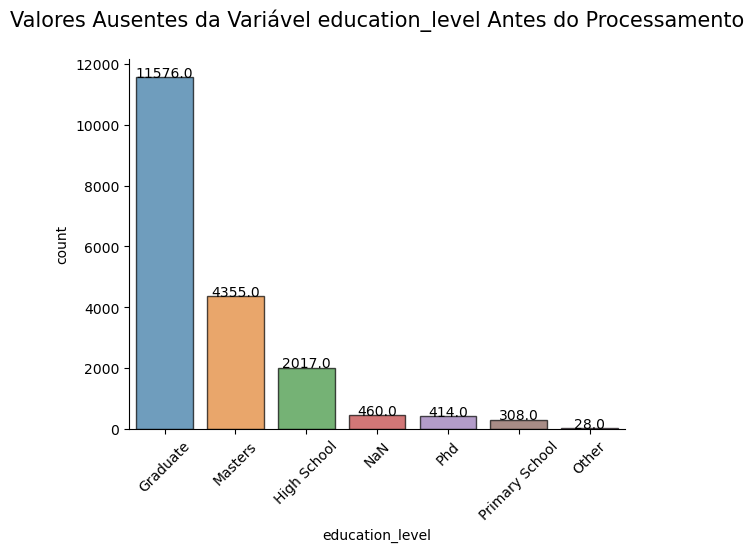

In [70]:
sns.countplot(data= new_df.fillna('NaN'), x= 'education_level', alpha = 0.7, edgecolor = 'black')
sns.despine()
plt.xticks(rotation=45)
bound=ax.get_xbound()
ax=plt.gca()
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 10)
plt.title('Valores Ausentes da Variável education_level Antes do Processamento\n', fontsize = 15)
plt.show()

In [71]:
nan_index = new_df[(new_df['education_level'].isna())].index

In [72]:
new_df['education_level'][nan_index] = 'Other'

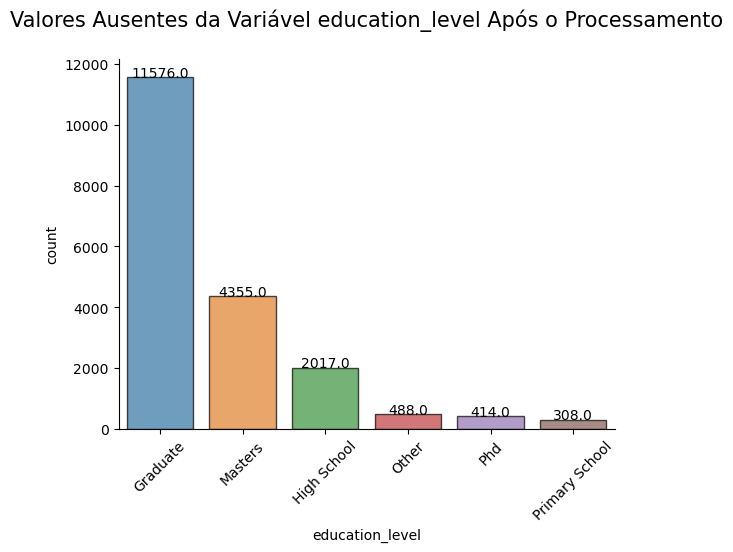

In [73]:
sns.countplot(data= new_df.fillna('NaN'), x= 'education_level', alpha = 0.7, edgecolor = 'black')
sns.despine()
plt.xticks(rotation=45)
bound=ax.get_xbound()
ax=plt.gca()
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 10)
plt.title('Valores Ausentes da Variável education_level Após o Processamento\n', fontsize = 15)
plt.show()

In [74]:
#Tratando valores ausentes da variável 'experience'
new_df['experience'].value_counts(dropna = False)

experience
>20      3281
5        1427
4        1402
3        1351
6        1214
2        1124
7        1028
10        982
9         980
8         802
15        685
11        664
14        586
1         549
<1        520
16        506
12        494
13        399
17        342
19        304
18        279
20        148
NaN        63
Other      28
Name: count, dtype: int64

In [75]:
#Percentual de valores ausentes
percent_missing = new_df.isnull().sum() / len(new_df) * 100
percent_missing

city_development_index    0.000000
experience                0.328844
enrolled_university       0.000000
relevent_experience       0.000000
education_level           0.000000
company_type              0.000000
major_discipline          0.000000
target                    0.000000
dtype: float64

In [76]:
new_df['experience'].isnull().sum()

63

In [77]:
new_df.shape

(19158, 8)

In [78]:
new_df = new_df.dropna()

In [79]:
new_df.shape

(19095, 8)

In [80]:
percent_missing = new_df.isnull().sum() / len(new_df) * 100
percent_missing

city_development_index    0.0
experience                0.0
enrolled_university       0.0
relevent_experience       0.0
education_level           0.0
company_type              0.0
major_discipline          0.0
target                    0.0
dtype: float64

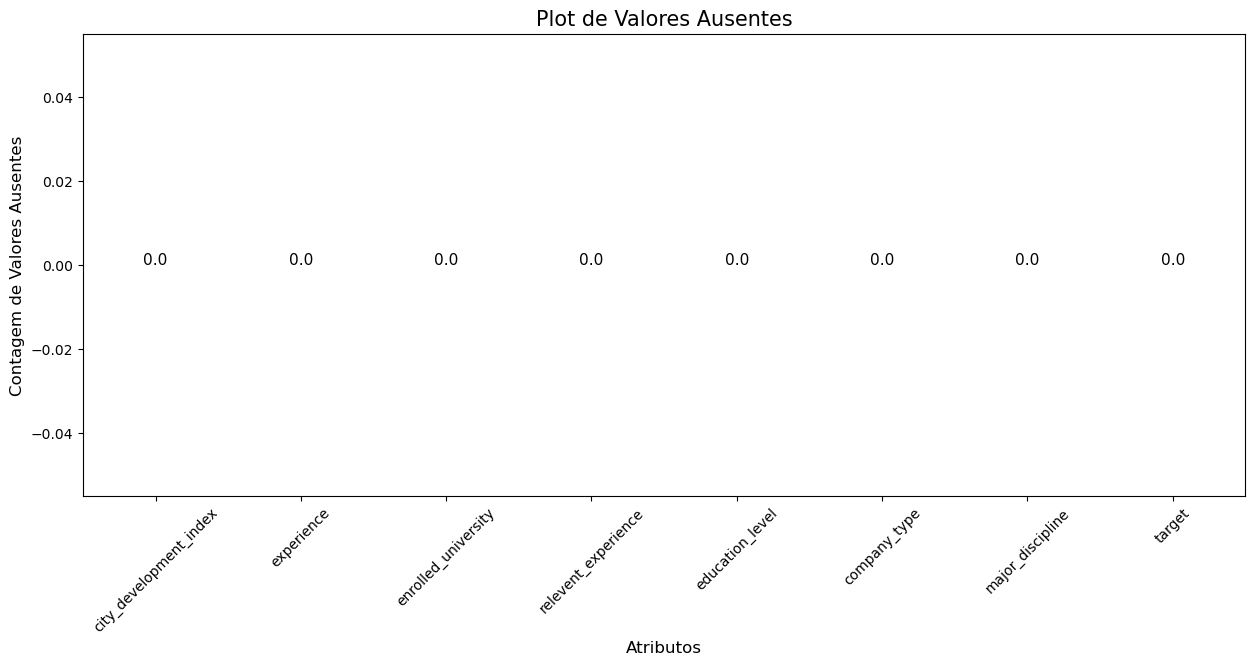

In [82]:
#Valores ausentes por coluna
null_df = new_df.isna().sum().reset_index()

#figura
fig, ax = plt.subplots(figsize = (15, 6))

#Barplot
sns.barplot(x = null_df['index'], y = null_df[0], palette = 'husl')
plt.xlabel('Atributos', fontsize = 12)
plt.ylabel('Contagem de Valores Ausentes', fontsize = 12)
plt.xticks(rotation = 45)
plt.title('Plot de Valores Ausentes', fontsize = 15)

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, (p.get_height())), ha = 'center', color = 'black', size = 11)


plt.show()

In [83]:
#ajuste dos dados
new_df.head()

,city_development_index,experience,enrolled_university,relevent_experience,education_level,company_type,major_discipline,target
0,0.92,>20,no_enrollment,Has relevent experience,Graduate,Other,STEM,1.0
1,0.776,15,no_enrollment,No relevent experience,Graduate,Pvt Ltd,STEM,0.0
2,0.624,5,Full time course,No relevent experience,Graduate,Other,STEM,0.0
3,0.789,<1,Other,No relevent experience,Graduate,Pvt Ltd,Business Degree,1.0
4,0.767,>20,no_enrollment,Has relevent experience,Masters,Funded Startup,STEM,0.0


In [85]:
new_df['enrolled_university'] = new_df['enrolled_university'].replace('no_enrollment', 'No enrollment')

In [86]:
new_df.head()

,city_development_index,experience,enrolled_university,relevent_experience,education_level,company_type,major_discipline,target
0,0.92,>20,No enrollment,Has relevent experience,Graduate,Other,STEM,1.0
1,0.776,15,No enrollment,No relevent experience,Graduate,Pvt Ltd,STEM,0.0
2,0.624,5,Full time course,No relevent experience,Graduate,Other,STEM,0.0
3,0.789,<1,Other,No relevent experience,Graduate,Pvt Ltd,Business Degree,1.0
4,0.767,>20,No enrollment,Has relevent experience,Masters,Funded Startup,STEM,0.0


In [87]:
x = new_df.drop(columns = ['target'])
y = new_df['target']

# Relatório Final 

Com base em nossa análise observamos que as variáveis mais relevantes para identificar um bom candidato são:

- Índice de Desenvolvimento da cidade onde mora o candidato.
- Tempo de experiência profissional.
- Se está ou não matriculado em um curso universitário.
- Se tem ou não experiência relevante.
- O nível educacional.
- O tipo de empresa que o candidato trabalhou ou trabalha atualmente.
- A especialização na graduação (quando for o caso).

Não são relevantes para a análise:

- O ID do candidato.
- O código da cidade do candidato.
- O gênero.
- A última vez que o candidato esteve empregado.
- O tamanho da empresa (quando for o caso).
- Total de horas de treimamento.

Recomendações do Analista de Dados:

- O RH pode desenvolver um método de coleta de dados para obter outros recursos a fim de melhorar a qualidade dos dados e tornar o trabalho de análise mais preciso.

- O RH pode procurar candidatos que vêm de cidades com índice de desenvolvimento urbano mais baixo, sem experiência relevante, nível de educação superior e menor experiência de trabalho para ter maior chance de encontrar candidatos que estão procurando um emprego.

- O RH pode tornar o treinamento mais compacto porque muitas pessoas não precisam de muito tempo para concluir o treinamento.